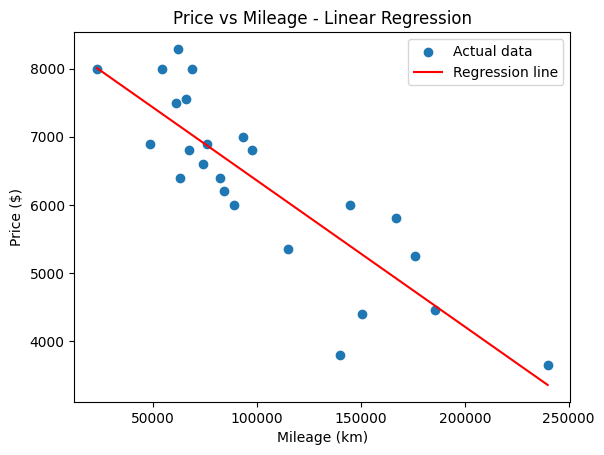

In [3]:
import math
import json
import matplotlib.pyplot as plot

#changeable settings
learningRate0 = 1
learningRate1 = 0.00007
error = 1e-6
scaling = 1000

# variables
file_contents = ""
file_milage = []
file_price = []
m = 0 # m is the total number of entries in the dataset cuz we wanna know the average, which is sum / total entries
theta0 = 0
theta1 = 0
r_squared_arr = []

def calc_estimate_price(milage):
	return theta0 + (theta1 * milage)

def calc_tmpTheta0():
	summation = 0
	for i in range(m):
		summation += calc_estimate_price(file_milage[i] / scaling) - file_price[i]
	return learningRate0 * (1/m) * summation

def calc_tmpTheta1():
	summation = 0
	for i in range(m):
		summation += (calc_estimate_price(file_milage[i] / scaling) - file_price[i]) * (file_milage[i] / 1000)
	return learningRate1 * (1/m) * summation


def process_file_contents():
	global m
	# split file contents into each line
	lines = file_contents.split('\n')
	if len(lines) <= 0:
		raise Exception("Error: File empty!!")
	
	#start from 1 to skip header
	for i in range(1, len(lines)):
		line_parts = lines[i].split(',')
		if len(line_parts) > 1:
			file_milage.append(float(line_parts[0].strip()))
			file_price.append(float(line_parts[1].strip()))
	
	m = len(file_milage)

def readfile():
	global file_contents
	file = open("data.csv")
	file_contents = file.read()
	file.close()

def train_model():
	global theta0, theta1, mse

	while True:

		tmpTheta0 = calc_tmpTheta0()
		tmpTheta1 = calc_tmpTheta1()

		if math.isnan(tmpTheta0) or math.isnan(tmpTheta1):
			print("NaN detected! Stopping calculation...")
			break

		if abs(tmpTheta0) < error and abs(tmpTheta1) < error:
			break
	
		theta0 -= tmpTheta0
		theta1 -= tmpTheta1

	theta1 /= scaling

def write_theta():
	params = {
		"theta0": theta0,
		"theta1": theta1
	}

	try:
		f = open("params.json", "w")
		f.write(json.dumps(params))
		f.close()
	except Exception:
		print("Failed to save params")

# bonus
def plot_milage_vs_price():
	#scatter plot
	plot.scatter(file_milage, file_price, label='Actual data')
    
    #linear regression line
	min_milage = min(file_milage)
	max_milage = max(file_milage)
	x_line = []
	y_line = []
	for milage in range(int(min_milage), int(max_milage), 1000): #calculate every 1000km
		x_line.append(milage)
		y_line.append(theta0 + (theta1 * milage))
    
	plot.figure(1)
	plot.plot(x_line, y_line, color="red", label='Regression line')
	plot.xlabel('Mileage (km)')
	plot.ylabel('Price ($)')
	plot.title('Price vs Mileage - Linear Regression')
	plot.legend()
	plot.show()

def plot_rs_squared():
	plot.plot(range(len(r_squared_arr)), label='R2 Linear Regression Error')
	plot.xlabel('Iteration')
	plot.ylabel('R2 error')
	plot.title('R2 Linear Regression Error')
	plot.legend()
	plot.show()

def calculate_r_squared():
    mean_price = sum(file_price) / m

    ss_tot = 0
    for price in file_price:
        ss_tot += (price - mean_price) ** 2

    ss_res = 0
    for i in range(m):
        predicted = theta0 + (theta1 * (file_milage[i] / scaling))
        ss_res += (file_price[i] - predicted) ** 2
    
    r_squared = 1 - (ss_res / ss_tot)
    r_squared_arr.append(r_squared)


if __name__ == "__main__":
	readfile()
	process_file_contents()
	train_model()
	write_theta()
	plot_milage_vs_price()

I ESCAPED ENGINEERING BY STUDYING CS NOW ITS BACK TO TRAUMATISE ME

First function:
Linear function (y = mx + c)
ESTIMATES the price only

Second and third function:
Partial derivatives of the main cost function, which is a cone / bowl shaped 3D graph with a minimum point where cost is the least
We basically wanna find that min point, so we need to find the point where tmpTheta is the least